---
---

<table align="center" style="border-collapse: collapse; border: none; width: 100%;">
  <tr>
    <td style="border: none; width: 15%;">
      <img src="../logos/spt_logo.jpg" alt="SPT Logo" style="width: 100%; height: auto;">
    </td>
    <td style="border: none; text-align: center; vertical-align: middle; padding: 0 30px; width: 50%;">
      <span style="font-size: 4vw; font-weight: bold;">SPT-3G D1 T&E</span>
    </td>
    <td style="border: none; width: 15%;">
      <img src="../logos/candl_logo.png" alt="CANDL Logo" style="width: 100%; height: auto;">
    </td>
  </tr>
</table>

---
---

This tutorial introduces you to working with SPT-3G D1 T&E data in `candl`. `candl` is a python-based, differentiable CMB likelihood code designed to make analysis easier and more flexible.

__Overview:__

[Part I: Classical Analysis](#part1)

This part covers the basics: how to initialise the likelihood, access the band powers, understand the data model, and evaluate the likelihood.
It uses the full multi-frequency likelihood.

[PART II: Differentiable Techniques](#part2)

This part covers differentiable techniques: gradient-based minmimisation, the propagation of band power biases to parameters, and gradient-based sampling.
It uses the CMB-only `SPTlite` likelihood.

__Resources:__
- [SPT candl data repository](https://github.com/SouthPoleTelescope/spt_candl_data)
- [SPT-3G D1 paper (UPDATE)](https://github.com/SouthPoleTelescope/spt_candl_data)
- [`candl` documentation](https://candl.readthedocs.io/en/latest/)
- [`candl` repository](https://github.com/Lbalkenhol/candl)
- [`candl` paper](https://arxiv.org/abs/2401.13433)

In [1]:
# Necessary imports and setup
%matplotlib inline

# Part I
import numpy as np
import yaml
from copy import deepcopy

import candl
import candl.tools
import candl.interface
import candl.plots
import spt_candl_data

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

candl.plots.set_plot_style()

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})


---

<a id='part1'></a>

# PART I: Classical Analysis

This part teaches the basics of interacting with the SPT data through `candl`:

* Initialising the likelihood
* Accessing different data products to plot the band powers
* Evaluating the likelihood
* Plotting residuals
* Working with transformations in the data model

<hr width="100%" style="border-style: none none dotted" color="#FFFFFF" size="6">

## Likelihood Initialisation

You can initialise the likelihood by simply pointing to the data set's `.yaml` file. If you have the `spt_candl_library` module installed you can use the shortcut `spt_candl_data.SPT3G_D1_TnE`. The initialisation will produce some feedback that tells you what spectra are loadded, what will be done to model spectra before they are compared to the data, and any priors that are applied. There are different optional keywords you can supply to modify the likelihood at this stage (e.g. to remove internal priors or overwrite the data vector), check out the [`candl` documentation](https://candl.readthedocs.io/en/latest/) to learn more.

In [2]:
# Initialise the likelihood
candl_like = candl.Like(spt_candl_data.SPT3G_D1_TnE)

Successfully initialised candl likelihood 'SPT-3G D1 TnE' (type: <class 'candl.likelihood.Like'>).
Data loaded from '/Users/lennart/Research/spt_candl_data/spt_candl_data/SPT3G_D1_TnE/'.
Functional likelihood form: gaussian
--------------------------------------------------------------------------------
It will analyse the following spectra:

TT 90x90     (52 bins, bin centres spanning ell = 424.7 - 2974.5)
TE 90x90     (72 bins, bin centres spanning ell = 424.6 - 3974.6)
EE 90x90     (72 bins, bin centres spanning ell = 424.5 - 3974.5)
TT 90x150    (52 bins, bin centres spanning ell = 424.7 - 2974.5)
TE 90x150    (72 bins, bin centres spanning ell = 424.6 - 3974.6)
TE 150x90    (72 bins, bin centres spanning ell = 424.6 - 3974.6)
EE 90x150    (72 bins, bin centres spanning ell = 424.5 - 3974.5)
TT 90x220    (52 bins, bin centres spanning ell = 424.7 - 2974.5)
TE 90x220    (72 bins, bin centres spanning ell = 424.6 - 3974.6)
TE 220x90    (72 bins, bin centres spanning ell = 424.6 - 397

<hr width="100%" style="border-style: none none dotted" color="#FFFFFF" size="6">

## Data Access

The SPT band powers are stored as a long vector with all measurements concatenated. The order is specified by the atrtibute `.spec_order` (which matches the output of the initialisation above). The following attributes are often useful:

* `.spec_order`: a list specifying the order of the spectra in the data vector
* `.data_bandpowers`: a long vector of band powers
* `.covariance`: the covariance matrix
* `.bins_start_ix`, `.bins_stop_ix`: lists that contain start and stop indices for the spectra
* `.N_bins`: a list containing the number of bins of each spectrum
* `.effective_ells`: the weighted bins centres of all all spectra

The code below uses these attributes to plot the band powers

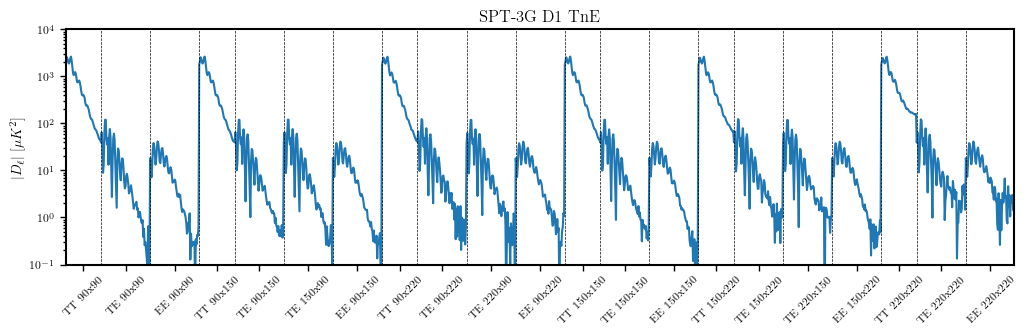

In [3]:
# Plot all band powers on one plot
plt.close()

# Set figure size
fig = plt.gcf()
fig.set_size_inches(3 * 3.464, 1 * 3.464)

# Plot the band powers
plt.plot(abs(candl_like.data_bandpowers))

# Indicate the different spectra
for i, spec in enumerate(candl_like.spec_order[:-1]):    
    plt.axvline(candl_like.bins_stop_ix[i], color="k", ls="--", lw=0.5)

# Finish plot (limits, ticks, labels, etc.)
plt.xlim(0, candl_like.N_bins_total-1)
plt.xticks(candl_like.bins_start_ix+(candl_like.bins_stop_ix-candl_like.bins_start_ix)/2,
           candl_like.spec_order,
           rotation=45)
plt.ylabel("$|D_\ell| \; [\mu K^2]$")
plt.yscale("log")
plt.ylim((1e-1, 1e4))
plt.title(candl_like.name)
plt.tight_layout()

plt.show()


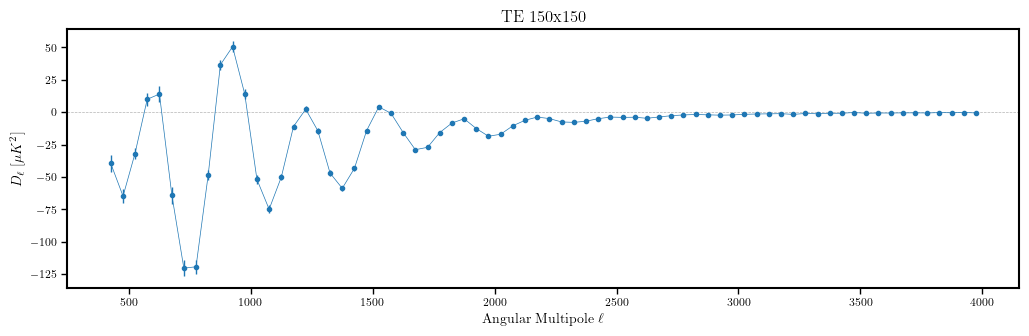

In [4]:
# Let's plot a single spectrum on a nice scale with error bars
# You might have to zoom in to see the error bars!

spec_to_plot = "TE 150x150"
ix_of_spec = candl_like.spec_order.index(spec_to_plot)

plt.close()

# Set figure size
fig = plt.gcf()
fig.set_size_inches(3 * 3.464, 1 * 3.464)

# Plot residuals and horizonal line
plt.errorbar(candl_like.effective_ells[candl_like.bins_start_ix[ix_of_spec]:candl_like.bins_stop_ix[ix_of_spec]],
             candl_like.data_bandpowers[candl_like.bins_start_ix[ix_of_spec]:candl_like.bins_stop_ix[ix_of_spec]],
             yerr=np.sqrt(np.diag(candl_like.covariance)[candl_like.bins_start_ix[ix_of_spec]:candl_like.bins_stop_ix[ix_of_spec]]),
             lw=0.5,
             marker="o",
             ms=3,
             elinewidth=1)

if candl_like.spec_types[ix_of_spec] == "TE":
     plt.axhline(0, color="0.7", ls="--", lw=0.5)
else:
     plt.yscale("log")

# Finish plot with limits, ticks, labels
plt.title(spec_to_plot)
plt.ylabel("$D_\ell \; [\mu K^2]$")
plt.xlabel("Angular Multipole $\ell$")

plt.tight_layout()

plt.show()

<hr width="100%" style="border-style: none none dotted" color="#FFFFFF" size="6">

## Evaluating the Likelihood

To evaluate the likelihood, supply a dictionary of CMB spectra and nuisance parameter values. The format expected is as follows:

`{'Dl': {'TT': ..., ...}, 'nuisance_par': ..., ...}`

CMB spectra are expected as Dls starting at `ell=2`, going up to the `.ell_max` of the likelihood. Below, we'll load a pre-calculated CMB spectrum from a file as well as a dictionary of all necessary parameter values. We will calculate our own predictions in the second part of this tutorial.

With the dictionary in the right format, we can call `.log_like()`. We will also calculate the `chi2` - note that this is not exactly `-2*candl_like.log_like()` as the `.log_like()` in ``candl`` function also applies some priors (as listed during initialisation). The first evaluations of these two functions are a little slow if you have JAX installed, as they are both jitted - but subsequent evaluations are much faster.


In [5]:
# Load a pre-calculated CMB spectrum and read in a dictionary of fiducial parameters
with open("../spt_candl_data/tests/SPT3G_D1_TnE_test.yaml", "r") as f:
    test_dict = yaml.load(f, Loader=yaml.loader.SafeLoader)
test_spec = np.loadtxt(f"../spt_candl_data/tests/{test_dict['test_spectrum']}")
pars_for_like = deepcopy(test_dict["param_values"])
pars_for_like["Dl"] = {}
test_spec_save_order = ["ell", "TT", "TE", "EE", "BB", "pp", "kk"]
for i, spec in enumerate(test_spec_save_order):
    pars_for_like["Dl"][spec] = test_spec[:, i]

In [6]:
# Evaluate the likelihood
candl_like.log_like(pars_for_like)

Array(-690.15045242, dtype=float64)

In [7]:
# Calculate the chi2 value
candl_like.chi_square(pars_for_like)

Array(1373.28025449, dtype=float64)

<hr width="100%" style="border-style: none none dotted" color="#FFFFFF" size="6">

## Plotting Residuals

Let's see what the residuals look like with respect to this model. We want to compare the full model prediction, i.e. the sample CMB spectrum with the data model applied, to the measured band powers. The functions `.get_model_specs()` and `.bin_model_specs()` allow you to do this. We'll take a closer look at what the data model is after this.

In [8]:
# Transform CMB spectra and bin
model_spectrum = candl_like.get_model_specs(pars_for_like)# apply the data model
binned_model_spectrum = candl_like.bin_model_specs(model_spectrum)# bin into band powers

# Grab the error bars
error_bars = np.sqrt(np.diag(candl_like.covariance))

# Calculate residuals
residuals = binned_model_spectrum - candl_like.data_bandpowers
relative_residuals = residuals / error_bars


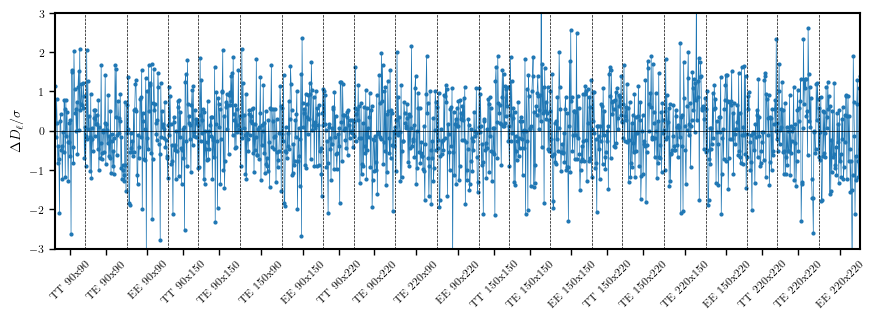

In [9]:
# Plot the residuals
plt.close()

# Set figure size
fig = plt.gcf()
fig.set_size_inches(3 * 3.464, 1 * 3.464)

# Plot residuals and horizonal line
plt.plot(relative_residuals, lw=0.5, marker="o", ms=2)
plt.axhline(0, color="k", lw=0.5)

# Dividers for spectra
for i, spec in enumerate(candl_like.spec_order[:-1]):    
    plt.axvline(candl_like.bins_stop_ix[i],color="k", ls="--", lw=0.5)

# Finish plot with limits, ticks, labels
plt.xlim(0, len(relative_residuals)-1)
plt.ylim((-3, 3))
plt.xticks(candl_like.bins_start_ix+(candl_like.bins_stop_ix-candl_like.bins_start_ix)/2,
           candl_like.spec_order,
           rotation=45)
plt.subplots_adjust(bottom=0.2)
plt.ylabel(r"$\Delta D_\ell / \sigma$")

plt.show()


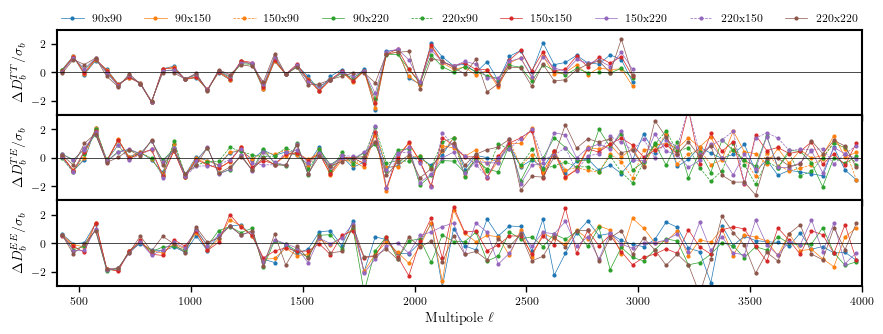

In [10]:
# The plot above is hard to read, to let's group things together by spectrum
plt.close()

# Set figure size
fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(3 * 3.464, 1 * 3.464), gridspec_kw={"hspace": 0})

# Define some unique colours and line styles for each frequency combination
# TE needs special attention, because it has pairs like 90x150 and 150x90
spec_cols = {}
spec_ls = {}
c = 0
for i, freq_pair in enumerate(candl_like.spec_freqs):
    spec_id = "x".join(freq_pair)
    if spec_id not in spec_cols:
        if "x".join(freq_pair[::-1]) in spec_cols:
            spec_cols[spec_id] = spec_cols["x".join(freq_pair[::-1])]
            spec_ls[spec_id] = "--"
        else:
            spec_cols[spec_id] = sns.color_palette()[c]
            spec_ls[spec_id] = "-"
            c += 1

# Plot residuals and horizonal line
for i, spec_type in enumerate(["TT", "TE", "EE"]):
    for j, spec in enumerate(candl_like.spec_order):
        if spec_type in spec:
            ax[i].plot(candl_like.effective_ells[candl_like.bins_start_ix[j]:candl_like.bins_stop_ix[j]],
                       relative_residuals[candl_like.bins_start_ix[j]:candl_like.bins_stop_ix[j]],
                       lw=0.5,
                       marker="o",
                       color=spec_cols[spec[3:]],
                       ls=spec_ls[spec[3:]],
                        label=spec[3:],
                       ms=2)
    ax[i].axhline(0, color="k", lw=0.5)
    ax[i].set_ylabel(f"$\\Delta D^{{{spec_type}}}_b / \\sigma_b$")

# Finish plot with limits, ticks, labels
ax[0].set_ylim((-3, 3))
ax[0].set_xlim((400, 4000))
ax[1].legend(ncol=len(spec_cols), loc="upper center", bbox_to_anchor=(0.5, 2.3), fontsize=8, frameon=False)
plt.subplots_adjust(top=0.85)
ax[-1].set_xlabel("Multipole $\\ell$")

plt.show()


<hr width="100%" style="border-style: none none dotted" color="#FFFFFF" size="6">

## Data Structure and Data Model

Prior to the comparison above, the likelihood adjusts the CMB spectra to make for a fair comparison to the data. The different transformations that are applied make up the data model. These are stored as objects in the `.data_model` list. The initialisation message at the start tells you what they are. Below we will grab one of them - the contamination due to galactic dust in the EE spectra - and interact with it. It requires three paramters `EE_PolGalDust_Amp`, `EE_PolGalDust_Beta`, and `EE_PolGalDust_Alpha` in order to produce predictions. The likelihood includes priors on these parameters, so we will grab their central values and look what the contamination is expected to look like. The internal priors are - similar to the data model - stored in a `.priors` list. For details, see the [`candl` documentation](https://candl.readthedocs.io/en/latest/).

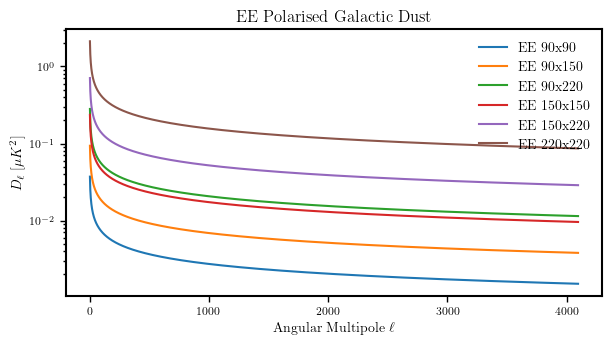

In [11]:
# Grab EE dust module
EE_dust_module_ix = [transformation.descriptor for transformation in candl_like.data_model].index("EE Polarised Galactic Dust")
EE_dust_module = candl_like.data_model[EE_dust_module_ix]

# Grab the parameter values from the prior
EE_dust_par_names = [p for p in EE_dust_module.param_names]
EE_dust_params = {p:None for p in EE_dust_par_names}
EE_dust_prior = {p:None for p in EE_dust_par_names}
for p in list(EE_dust_params.keys()):
    for prior in candl_like.priors:
        if p in prior.par_names:
            EE_dust_params[p] = prior.central_value[prior.par_names.index(p)]
            EE_dust_prior[p] = prior.prior_covariance[prior.par_names.index(p),prior.par_names.index(p)]
            break

# Calculate the expected EE dust contamination
EE_dust_contamination = EE_dust_module.output(EE_dust_params)

# Plot
plt.close()

# Set figure size
fig = plt.gcf()
fig.set_size_inches(2 * 3.464, 1 * 3.464)

# Plot all EE contributions
for i, spec in enumerate(candl_like.spec_order):
    if candl_like.spec_types[i] == "EE":
        plt.plot(candl_like.ells, EE_dust_contamination[i*candl_like.N_ell_bins_theory:(i+1)*candl_like.N_ell_bins_theory], label=spec)

plt.legend()

plt.title(EE_dust_module.descriptor)
plt.ylabel("$D_\ell \; [\mu K^2]$")
plt.xlabel("Angular Multipole $\ell$")
plt.yscale("log")

plt.show()


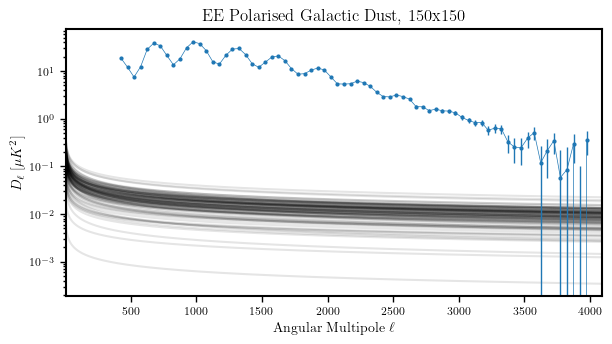

In [12]:
# Plot the dust contamination for a single spectrum, draw multiple realisations from the prior
spec_to_plot = "EE 150x150"
ix_of_spec = candl_like.spec_order.index(spec_to_plot)

# Plot
plt.close()

# Set figure size
fig = plt.gcf()
fig.set_size_inches(2 * 3.464, 1 * 3.464)

# Sample from the prior
N_samples = 100
EE_dust_prior_cov = np.diag(np.array([EE_dust_prior[p] for p in EE_dust_par_names]))
EE_dust_prior_mean = np.array([EE_dust_params[p] for p in EE_dust_par_names])
EE_dust_samples = np.tile(EE_dust_prior_mean, (N_samples, 1)) + np.random.normal(0, 1, (N_samples, len(EE_dust_par_names))) @ np.linalg.cholesky(EE_dust_prior_cov).T

# Calculate CIB spectra and plot
for i in range(N_samples):
    EE_dust_contamination = EE_dust_module.output({p:EE_dust_samples[i,j] for j, p in enumerate(EE_dust_par_names)})
    plt.plot(candl_like.ells, EE_dust_contamination[ix_of_spec*candl_like.N_ell_bins_theory:(ix_of_spec+1)*candl_like.N_ell_bins_theory], label=spec, alpha=0.1, color="k")


# Plot spectrum
plt.errorbar(candl_like.effective_ells[candl_like.bins_start_ix[ix_of_spec]:candl_like.bins_stop_ix[ix_of_spec]],
         candl_like.data_bandpowers[candl_like.bins_start_ix[ix_of_spec]:candl_like.bins_stop_ix[ix_of_spec]],
         yerr=np.sqrt(np.diag(candl_like.covariance)[candl_like.bins_start_ix[ix_of_spec]:candl_like.bins_stop_ix[ix_of_spec]]),
            lw=0.5,
            marker="o",
            ms=2,
            elinewidth=1)

# Finish plot
plt.title(EE_dust_module.descriptor + ", " + "x".join(candl_like.spec_freqs[ix_of_spec]))
plt.ylabel("$D_\ell \; [\mu K^2]$")
plt.xlabel("Angular Multipole $\ell$")
plt.yscale("log")
plt.xlim((candl_like.ell_min, candl_like.ell_max))

plt.show()


---

<a id='part2'></a>

# PART II: Differentiable Techniques

As demonstrated in the paper, a lot of interesting applications are opened up by having ready access to derivatives of the likelihood. In this part, we use JAX's autodiff and cover:
* Building a fully differentiable pipeline from cosmological parameters to the likelihood value
* Shortcutting MCMC analyses (by minimising the likelihood using a gradient-based method and obtaining the Fisher matrix by evaluating the Hessian)
* Propagating a bias to the band powers through to cosmological parameters
* Gradient-based sampling

This part of the notebook uses the compressed, CMB-only `SPTlite` version of the likelihood. The multi-frequency version above is also differentiable, but working with `SPTlite` is simpler due to the reduced number of nuisance parameters and the smaller data vector.

Note that for a fully differentiable pipeline, we need a differentiable theory code. Here, we use the publicly available high-accuracy SPT `CosmoPower` emulators and load them into CosmoPower-JAX ([Spurio Mancini et al. 2021](https://arxiv.org/abs/2106.03846), [Piras et al. 2021](https://arxiv.org/abs/2305.06347), [Balkenhol et al. 2022](https://arxiv.org/abs/2212.05642)).
You can download the emulator models from [here](https://github.com/Lbalkenhol/candl/blob/b83201e3b92c75c062f2a8acd154bd01cac802ee/notebooks/SPT_ACT_summer_school_2024/cosmopower_models.zip). Depending on where you place them, you may have to modify the relevant file names.


In [13]:
# Imports for Part II
import jax
from jax import flatten_util
import jax.numpy as jnp

import scipy
import time

import blackjax

import getdist
from getdist.mcsamples import MCSamples
from getdist import plots, MCSamples

In [14]:
# Initialise SPTlite
candl_like = candl.Like(spt_candl_data.SPT3G_D1_TnE, variant="lite")

Successfully initialised candl likelihood 'SPT-3G D1 TnE - Main field (lite)' (type: <class 'candl.likelihood.Like'>).
Data loaded from '/Users/lennart/Research/spt_candl_data/spt_candl_data/SPT3G_D1_TnE/lite/'.
Functional likelihood form: gaussian
--------------------------------------------------------------------------------
It will analyse the following spectra:

TT lxl       (52 bins, bin centres spanning ell = 424.7 - 2974.5)
TE lxl       (72 bins, bin centres spanning ell = 424.6 - 3974.5)
EE lxl       (72 bins, bin centres spanning ell = 424.5 - 3974.5)
--------------------------------------------------------------------------------
A data model consisting of 4 transformations has been initialised.
The following transformations will be applied to the theory spectra in this order:

(1) Name: Aberration
    Type: <class 'candl.transformations.common.AberrationCorrection'>
(2) Name: TT Calibration (External)
    Type: <class 'candl.transformations.common.CalibrationAuto'>
(3) Name

<hr width="100%" style="border-style: none none dotted" color="#FFFFFF" size="6">

## Building a Differentiable Pipeline

We now connect our likelihood to a differentiable theory code to build a fully differentiable pipeline. We will create two functions that move from parameter values to the log likelihood value: one operating on a dictionary (similar to the case before) and one operating on a vector (numpy array) input.

In [15]:
# Load CosmoPower emulators
# this gives us a function that moves from a dictionary of cosmological parameters to a dictionary of CMB theory spectra
# This may produce some warning messages depending on what format the emulator files are in, and what version of CosmoPower you have, but (as long as nothing crashes) they can be ignored
# You may need to add a path depending on where you have the emulator files stored
cp_emulator_filenames = {"TT": "cmb_spt_TT_NN.npz",
                         "TE": "cmb_spt_TE_PCAplusNN.npz",
                         "EE": "cmb_spt_EE_NN.npz"}
pars_to_theory_specs = candl.interface.get_CosmoPowerJAX_pars_to_theory_specs_func(cp_emulator_filenames)

# Connect the emulators to the likelihood
like_dict = candl.tools.get_params_to_logl_func(candl_like, pars_to_theory_specs)# this function takes a dictionary as an input - like before but with cosmological parameters rather than a CMB spectrum

# Define fiducial parameters
fid_pars = {'H0': 67.37,
            'ombh2': 0.02233,
            'omch2': 0.1198,
            'ns': 0.9652,
            'logA': 3.043,
            'tau': 0.054,
            'Tcal': 1.0,
            'Ecal': 1.0}

# Define a mapping of parameter from the dictionary to a vector (sometimes it's easier to work with a vector compared to a dictionary)
fid_par_vec, par_unravel = jax.flatten_util.ravel_pytree(fid_pars)
par_index = par_unravel(np.arange(len(fid_par_vec)))

par_order = len(fid_pars)*[0]
for par in list(par_index.keys()):
    par_order[par_index[par]] = par

# Grab a version of the likelihood that takes a parameter vector as input - often more convenient
like_vec = lambda par_vec: like_dict(par_unravel(par_vec))

Tried to load pickle file from pre-trained model, but failed.
This usually means that you have TF>=2.14, or that you are loading a model that was trained on PCA but loaded with the log (or viceversa), or that you are loading a non-standard model from the cosmopower-organization repo.
Falling back to the dictionary, if case this also fails or does not output the right shape make sure you ran the `convert_tf214.py` script, and that a `.npz` file exists among the trained models, and that you ran `pip install .`. Also make sure that you are asking for the right probe between `custom_log` and `custom_pca`.
Tried to load pickle file from pre-trained model, but failed.
This usually means that you have TF>=2.14, or that you are loading a model that was trained on PCA but loaded with the log (or viceversa), or that you are loading a non-standard model from the cosmopower-organization repo.
Falling back to the dictionary, if case this also fails or does not output the right shape make sure you r

<hr width="100%" style="border-style: none none dotted" color="#FFFFFF" size="6">

## Short-cutting MCMC Analyses

One key application of a differentiable likelihood that was indespensible for the analysis was the short-cutting of MCMC analyses. By minimising `SPTlite` and evaluating the Hessian, we can get a good approximation of the real parameter posteriors. Below, we use scipy's truncated Newton minimizer, which is is a simple gradient-descend method. There are more advanced and robust algorithms, but given that the posterior is close to Gaussian and that we typically have a good starting point for CMB analyses, the Newton algorithm is good enough. For intructions on connecting to other minimisers and in particular the [`Optax` library](https://github.com/google-deepmind/optax), see the [`candl` documentation](https://candl.readthedocs.io/en/latest/).

This procedure should take <10 seconds on a laptop!

In [16]:
# Minimise using scipy (note that the minimiser expects a different sign convention)
like_for_minimiser = lambda p: -like_vec(p)
deriv_like_for_minimiser = jax.jit(jax.jacrev(like_for_minimiser))# jacrev gives the derivatives and tends to be faster than jacfwd in this case

all_min_par_steps = [fid_par_vec]
res = scipy.optimize.minimize(like_for_minimiser,
                        all_min_par_steps[0],
                        method = "TNC",
                        jac = deriv_like_for_minimiser,
                        callback=lambda p: all_min_par_steps.append(p),
                        options={"disp": True,
                                 "maxfun": 1000,
                                 "ftol": 1e-8})

# Juggle the output - we want to keep track of all steps of the minimiser and the likelihood at every point
all_min_par_steps = np.asarray(all_min_par_steps)
all_min_logls = jax.vmap(like_vec)(all_min_par_steps)
min_bf_ix = np.argmax(all_min_logls)
all_min_eval_points = [{p: all_min_par_steps[ix,i] for i, p in enumerate(par_order)} for ix in range(np.shape(all_min_par_steps)[0])]

min_results_dict = {"best fit": all_min_eval_points[min_bf_ix],
        "best fit ix": min_bf_ix,
        "logl": np.asarray(all_min_logls),
        "eval points": all_min_eval_points,
        "success": res.success}

# Finally, we can calculate the Fisher matrix by evaluating the Hessian of the likelihood at the best fit point
fisher_matrix = -np.linalg.inv(jax.hessian(like_vec)(all_min_par_steps[min_bf_ix]))


  NIT   NF   F                       GTG
    0    1  8.250118735308413E+01   4.67422139E+05
tnc: fscale = 0.000854036
    1    6  7.962469964286912E+01   1.48709354E+04
    2   11  7.887240094066932E+01   5.53751605E+05
    3   16  7.873697445146271E+01   3.55161310E+05
    4   21  7.863899342980093E+01   2.47477549E+04
    5   25  7.862232085829690E+01   2.40064136E+03
    6   30  7.859681824729252E+01   2.85949796E+03
tnc: fscale = 0.0182243
    7   35  7.859644768449560E+01   1.31589909E+01
    8   40  7.859607597022810E+01   2.47673812E+01
    9   45  7.859593719798274E+01   3.83154935E+01
   10   50  7.859589821579165E+01   2.80536982E+00
   11   55  7.859586667709787E+01   1.66483599E+01
   12   59  7.859586612027492E+01   1.08811028E-02
tnc: fscale = 8.16539
   13   64  7.859586611016488E+01   8.52246384E-05
tnc: |fn-fn-1] = 2.94408e-09 -> convergence
   14   68  7.859586610722080E+01   9.19270475E-04
tnc: Converged (|f_n-f_(n-1)| ~= 0)


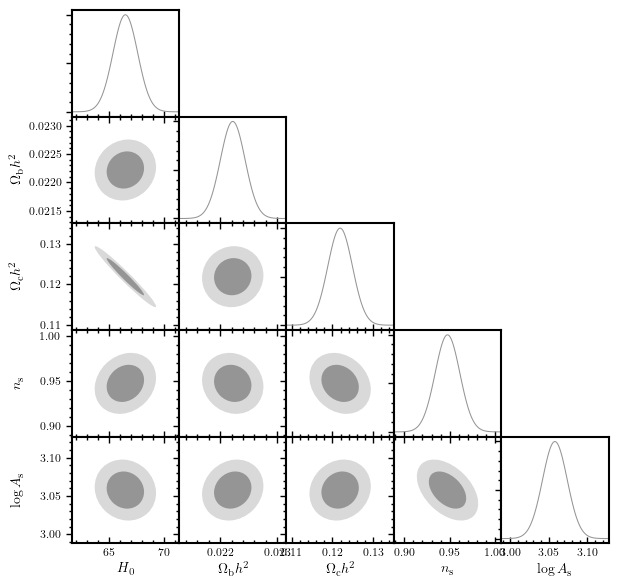

In [17]:
# Make a triangle plot showing the Fisher matrix at the best fit point
pars_to_plot = ["H0", "ombh2", "omch2", "ns", "logA"]

plt.close()

# Plot parameters
sigma_plot_range = 3
sigma_levels = 2

# There are some candl internal plotting routines to make this easier
ax = candl.plots.triangle_plot_from_cov(pars_to_plot = pars_to_plot,# which parameters to plot
                                        bf_point = min_results_dict["best fit"],# Best-fit point found above
                                        par_cov = fisher_matrix,# the parameter covariance matrix
                                        pars_in_cov = par_order,# the order of parameters in the covariance
                                        sigma_plot_range = 3.5,# sets the axes limits
                                        sigma_levels = 2)# how many sigma levels to plot

plt.show()

<hr width="100%" style="border-style: none none dotted" color="#FFFFFF" size="6">

## Propagating biases

Another key application of a differentiable likelihood during the analysis was the propagation of band power biases through to cosmological parameters. This works off a Taylor expansion of the likelihood around the best-fit point. You can find the mathematical background in [Eq. 6 of Kable et al. 2019](https://arxiv.org/pdf/1908.01626). In the example below, we see what the effect of a miscalibration of the EE spectrum is.

This should also take <10 seconds on a laptop!

In [18]:
# First, grab the derivates of the binned model spectra
get_binned_model_specs = lambda p: candl.tools.pars_to_model_specs(candl_like, p, pars_to_theory_specs)[1]
model_spec_derivs_dict = jax.jacfwd(get_binned_model_specs)(min_results_dict["best fit"])
model_spec_derivs_arr = np.zeros((candl_like.N_bins_total, len(fid_pars)))
for i, p in enumerate(par_order):
    model_spec_derivs_arr[:,i] = model_spec_derivs_dict[p]

# Move through array of rescalings
all_cals = np.linspace(-0.02, 0.02, 11)

all_par_shifts = []
for i, re_cal in enumerate(all_cals):

    # Create offset vector
    delta_bdp = np.zeros(len(candl_like.data_bandpowers))
    for i, spec in enumerate(candl_like.spec_types):
        if spec[:2] == "EE":
            delta_bdp[candl_like.bins_start_ix[i]:candl_like.bins_stop_ix[i]] = re_cal*candl_like.data_bandpowers[candl_like.bins_start_ix[i]:candl_like.bins_stop_ix[i]]
    
    # Calculate parameter shift
    delta_pars = fisher_matrix @ model_spec_derivs_arr.T @ np.linalg.inv(candl_like.covariance) @ delta_bdp

    # Shuffle into dictionaries
    offset_par_dict = {}
    for j, p in enumerate(par_order):
        offset_par_dict[p] = fid_pars[p] + delta_pars[j]
    all_par_shifts.append(offset_par_dict)

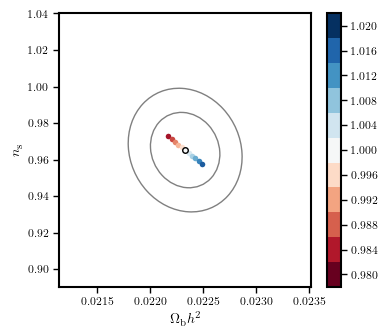

In [19]:
# Plot!
par1 = "ombh2"
par2 = "ns"

par1_ix = par_order.index(par1)
par2_ix = par_order.index(par2)

plt.close()

fig = plt.gcf()
fig.set_size_inches(1.15*3.464, 3.464)

# Plot the SPT contours
ax = plt.gca()
for i in [2,1]:
    candl.plots.add_confidence_ellipse(ax,
                                        fisher_matrix,
                                        par_order.index(par1),
                                        par_order.index(par2),
                                        fid_pars[par1],
                                        fid_pars[par2],
                                        i,
                                        ec="0.5",
                                        facecolor="None")

# Trajectory
all_cols = sns.color_palette("RdBu", len(all_cals))
for i in range(len(all_cals)):
    par_shift = all_par_shifts[i]
    
    if par_shift[par1] == fid_pars[par1]:
        plt.plot(par_shift[par1], par_shift[par2], marker="o", ms=4, color=all_cols[i], markeredgecolor="k", alpha=1, zorder=9999)
    else:
        plt.plot(par_shift[par1], par_shift[par2], marker="o", ms=4, color=all_cols[i], markeredgecolor="None", alpha=1)

# Colourbar on the right
cmap = plt.get_cmap("RdBu")
norm = mpl.colors.Normalize(vmin=1+np.amin(all_cals), vmax=1+np.amax(all_cals))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=1+all_cals,
             boundaries=1+np.linspace(np.amin(all_cals)-np.diff(all_cals)[0]/2, np.amax(all_cals)+np.diff(all_cals)[0]/2, len(all_cals)+1), ax=plt.gca())

# Plotting stuff
plt.xlim(fid_pars[par1]-5.5*np.sqrt(fisher_matrix[par1_ix,par1_ix]), fid_pars[par1]+5.5*np.sqrt(fisher_matrix[par1_ix,par1_ix]))
plt.ylim(fid_pars[par2]-5.5*np.sqrt(fisher_matrix[par2_ix,par2_ix]), fid_pars[par2]+5.5*np.sqrt(fisher_matrix[par2_ix,par2_ix]))

plt.xlabel(f"${candl.plots.PAR_LABEL_DICT[par1]}$")
plt.ylabel(f"${candl.plots.PAR_LABEL_DICT[par2]}$")

plt.tight_layout()

plt.show()


<hr width="100%" style="border-style: none none dotted" color="#FFFFFF" size="6">

## Gradient-based Sampling

Finally, let's sample from the posterior. Gradient-information helps us draw more independent samples. Together with the speed-up brought by jitting the likelihood and the use of a fast emulator, we can get nicely converged chains very quickly. Below, we use [`BlackJAX`](https://github.com/blackjax-devs/blackjax) and perform MCLMC sampling as introduced by [Robnik et al. 2022](https://arxiv.org/abs/2212.08549).

This should run in <1 minute on a laptop!


In [20]:
# We can make the sampling easier by working in a close-to unit Gaussian space.
# Based on the minimum we have already found and the Fisher matrix we can define such a transformtion
ref_point = jnp.asarray([min_results_dict["best fit"][p] for p in par_order])
fisher_chol = jnp.linalg.cholesky(fisher_matrix)
fisher_chol_inv = jnp.linalg.inv(fisher_chol)

# Helper functions to move to regular units from N(0,1)
jax.jit
def transform_from_zero_mean_unit_var(par_vec):
    return ref_point + (fisher_chol @ par_vec)

# Helper functions to move from regular units to N(0,1)
jax.jit
def transform_to_zero_mean_unit_var(par_vec):
    return fisher_chol_inv @ (par_vec - ref_point)

# Here, we grab a function that moves from normed parameters to logl all in one step.
like_vec_normed = jax.jit(lambda p: like_vec(transform_from_zero_mean_unit_var(p)))
like_vec_normed_deriv = jax.jit(jax.jacrev(like_vec_normed))


In [21]:
# Define the MCLMC inference loop
# This code is taken from the BlackJAX documentation (https://blackjax-devs.github.io/sampling-book/algorithms/mclmc.html)
def run_mclmc(logdensity_fn, num_steps, initial_position, key, transform, desired_energy_variance= 5e-4):
    init_key, tune_key, run_key = jax.random.split(key, 3)

    # create an initial state for the sampler
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key
    )

    # build the kernel
    kernel = lambda inverse_mass_matrix : blackjax.mcmc.mclmc.build_kernel(
        logdensity_fn=logdensity_fn,
        integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
        inverse_mass_matrix=inverse_mass_matrix,
    )

    # find values for L and step_size
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
        _
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        diagonal_preconditioning=False,
        desired_energy_var=desired_energy_variance
    )

    # use the quick wrapper to build a new kernel with the tuned parameters
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L=blackjax_mclmc_sampler_params.L,
        step_size=blackjax_mclmc_sampler_params.step_size,
    )

    # run the sampler
    _, samples = blackjax.util.run_inference_algorithm(
        rng_key=run_key,
        initial_state=blackjax_state_after_tuning,
        inference_algorithm=sampling_alg,
        num_steps=num_steps,
        transform=transform,
        progress_bar=False,
    )

    return samples, blackjax_state_after_tuning, blackjax_mclmc_sampler_params, run_key

In [22]:
# Define how many steps we want and use JAX's vmap to run multiple chains in parallel
# They will start from random points close to the best-fit

num_steps = 1000
transform = lambda state, info: state.position

def run_chain(rand_key):

    samples, initial_state, params, chain_key = run_mclmc(
    logdensity_fn=like_vec_normed,
    num_steps=num_steps,
    initial_position=jnp.array(np.random.normal(0, 1, len(ref_point))),
    key=rand_key,
    transform=transform)

    return samples

run_many_chains = jax.vmap(run_chain)

In [23]:
# Run 8 chains in parallel
n_chains = 8

t_start = time.time()
all_samples = run_many_chains(jnp.asarray([jax.random.key(i) for i in range(n_chains)])).block_until_ready()
t_stop = time.time()

print(f"Time taken: {t_stop - t_start}")


Time taken: 24.29203510284424


In [24]:
# Restore units to samples and convert to a GetDist MCSamples object
MCLMC_samples = jnp.apply_along_axis(transform_from_zero_mean_unit_var, -1, all_samples)

gd_samples_MCLMC = MCSamples(samples = np.array(MCLMC_samples),
                            names = par_order,
                            labels = [candl.plots.PAR_LABEL_DICT[p] if p in candl.plots.PAR_LABEL_DICT else p for p in par_order],
                            label='BlackJAX MCLMC')
gd_samples_MCLMC.loglikes = np.zeros(n_chains*num_steps)# BlackJAX doesn't return logl values, we set these to zero here

print(f"Convergence R-1 = {np.round(float(gd_samples_MCLMC.getGelmanRubin()), decimals=5)}")


Convergence R-1 = 0.00767


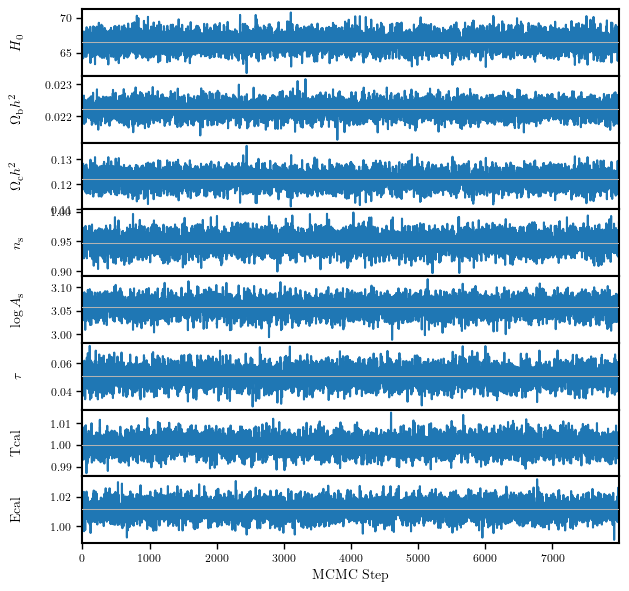

In [25]:
# Plot the samples!
# These should look like lovely white noise
plt.close()

fig, ax = candl.plots.plot_mcmc_chain_steps(gd_samples_MCLMC,# samples to plot
                                            list(fid_pars.keys()),# parameters to plot
                                            min_results_dict["best fit"],# best-fit point
                                            show_logl=False)# Order of paramters in the Fisher matrix
plt.show()

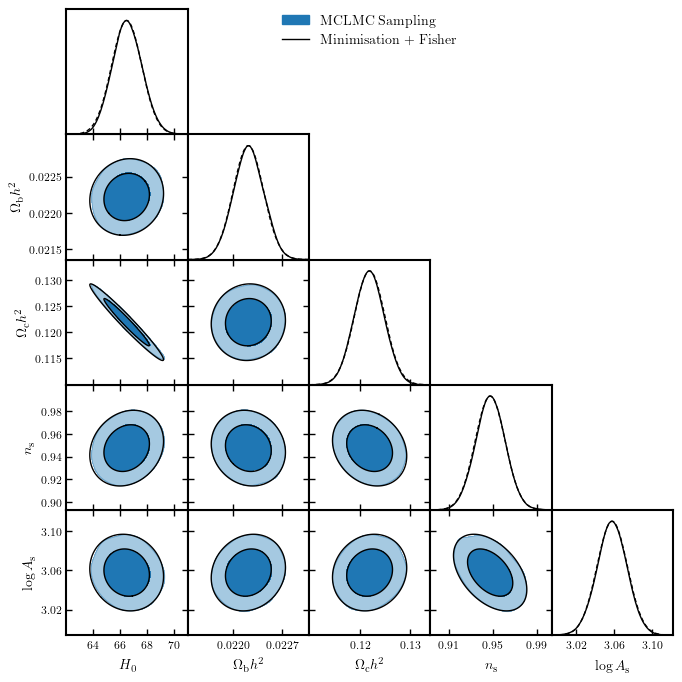

In [26]:
# Compare the Minimiser+Fisher matrix with the MCLMC samples
# Use getdist to create a standard triangle plot
# These should match pretty well

fisher_gauss_mix = getdist.gaussian_mixtures.GaussianND(np.array([min_results_dict["best fit"][p] for p in par_order]),
                                                        fisher_matrix,
                                                        names=par_order)

plt.close()

# Create the triangle plot
g = plots.get_subplot_plotter(width_inch=2*3.464, scaling=False, rc_sizes=True)
g.triangle_plot([gd_samples_MCLMC, fisher_gauss_mix],
                pars_to_plot,
                filled=[True, False],
                contour_colors=[sns.color_palette()[0], "k"],
                line_args=[{}, {'ls':"--", 'color':"k"}],
                legend_labels=["MCLMC Sampling", "Minimisation + Fisher"])

plt.show()